<h1 style="text-align: center;" markdown="1"><font color=green>Kaggle Zillow Competition</font> </h1>
<h3 style="text-align: center;" markdown="0">Fangjie</font> </h3>
***
<font color=green>**Description**: </font>
    https://www.kaggle.com/c/zillow-prize-1 

<font color=green>**Objective**:</font>  Build a model that predicts Zestimate's residual error:  
<font color=orange>$logerror=log(Zestimate Prediction)−log(Actual Sale Price)$ </font> 
***
<font color=green> ** Table of contents **</font> 
1. [load data sets](#section_1)   
1. [explore the data sets](#section_2)  
1. [merge data according to problem setup](#section_3)      
1. [prepare data for training](#section_4)  
    1. [do some simple feature engineering](#section_4_a)
    1. [generate some more features via SQL](#section_4_b)
    1. [let's build an ARIMA model to predict future logerror](#section_4_c)
    1. [define correct feature types and impute missing values](#section_4_d)
    1. [confirm final input feature quality](#section_4_e)
       1. [check feature importances](#section_4_e_1)
       2. [further check on some promising features](#section_4_e_2)
    1. [generate training & testing sets](#section_4_f)
1. [train models](#section_5)  
    1. [LightGBM](#section_5_a)
    1. [XgBoost](#section_5_b) 
    1. [random forest](#section_5_c) 
    1. [catboost](#section_5_d) 
1. [plots](#section_6)
plot learning curve & visualize result of each model (roc auc )     
1. [ensemble](#section_7)
ensemble & compare again 
1. [scoring](#section_8)
skipped for this demo


## import modules

In [1]:
# misc
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# general
import pandas as pd
import numpy as np
from scipy import stats
import time
import pickle
import itertools

# ML models
import pickle
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import explained_variance_score, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm

# time series models
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Visualisations
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from matplotlib.axes import Subplot
from pylab import rcParams
import seaborn as sns
import ggplot

<a id="section_1"></a>
#  1.  Load data

In [2]:
data_path = '~/Workspace/data-science/competitions/zillow/'

In [3]:
df_properties_2016 = pd.read_csv(data_path+'properties_2016.csv')
df_properties_2017 = pd.read_csv(data_path+'properties_2017.csv')
df_transactions_2016 = pd.read_csv(data_path+'train_2016_v2.csv',parse_dates=['transactiondate'])
df_transactions_2017 = pd.read_csv(data_path+'train_2017.csv',parse_dates=['transactiondate'])
sample_submission = pd.read_csv(data_path+'sample_submission.csv')

<a id="section_2"></a>
# 2. Check data

In [4]:
df_properties = df_properties_2016
df_transactions = df_transactions_2016

In [5]:
df_properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [6]:
df_properties.shape

(2985217, 58)

In [7]:
df_properties.dtypes

parcelid                          int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object
heatingorsystemtypeid           float64
latitude                        float64


In [8]:
#check uniqueness of parcelid
df_properties.parcelid.unique().shape[0] == df_properties.parcelid.shape[0]

True

In [9]:
# merge transaction file and properties to generate training files
df_train_2016 = pd.merge(df_transactions_2016, df_properties_2016, how = 'left', on = 'parcelid')
df_train_2017 = pd.merge(df_transactions_2017, df_properties_2017, how = 'left', on = 'parcelid')

In [10]:
df_train = df_train_2016
df_train.describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,9.027500e+04,90275.000000,28781.000000,261.000000,43.000000,90275.000000,90275.000000,16.0,57364.000000,89093.000000,...,95.000000,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,1783.000000,8.967000e+04
mean,1.298466e+07,0.011457,1.816372,7.229885,713.581395,2.279474,3.031869,4.0,5.565407,2.309216,...,311.694737,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,13.402692,6.049151e+13
std,2.504510e+06,0.161079,2.974168,2.716196,437.434198,1.004271,1.156436,0.0,1.900602,0.976172,...,346.354850,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,2.715966,2.046605e+11
min,1.071174e+07,-4.605000,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,...,18.000000,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.000000,6.037101e+13
25%,1.155950e+07,-0.025300,1.000000,7.000000,407.500000,2.000000,2.000000,4.0,4.000000,2.000000,...,100.000000,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,13.000000,6.037320e+13
50%,1.254734e+07,0.006000,1.000000,7.000000,616.000000,2.000000,3.000000,4.0,7.000000,2.000000,...,159.000000,1970.000000,1.000000,1.320000e+05,3.428720e+05,2015.0,1.929700e+05,4542.750000,14.000000,6.037615e+13
75%,1.422755e+07,0.039200,1.000000,7.000000,872.000000,3.000000,4.000000,4.0,7.000000,3.000000,...,361.000000,1987.000000,2.000000,2.105345e+05,5.405890e+05,2015.0,3.454195e+05,6901.090000,15.000000,6.059042e+13
max,1.629608e+08,4.737000,13.000000,21.000000,1555.000000,20.000000,16.000000,4.0,12.000000,20.000000,...,1366.000000,2015.000000,4.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,99.000000,6.111009e+13


In [11]:
df_train.shape

(90275, 60)

### check target variable - logerror

Text(0.5,1,u'histogram of traget variable: logerror ')

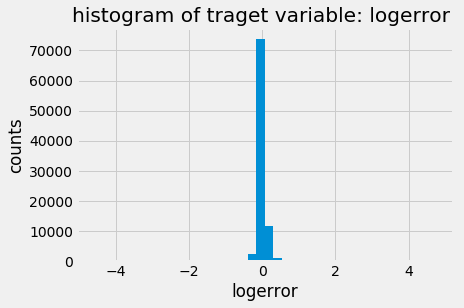

In [12]:
# a simple histogram
ax = df_train.logerror.hist(bins = 40)
ax.set_xlabel("logerror")
ax.set_ylabel("counts")
ax.set_title("histogram of traget variable: logerror ")

Text(0.5,1,u'histogram of traget variable: logerror ')

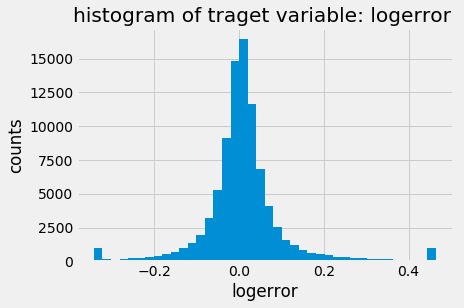

In [13]:
# this looks weird - there seems to be some extreme outliers
# let me remove them and plot again
# convert to top 1% and bottom 1%
ulimit = np.percentile(df_train.logerror.values, 99)
llimit = np.percentile(df_train.logerror.values, 1)
df_train['logerror'].ix[df_train['logerror']>ulimit] = ulimit
df_train['logerror'].ix[df_train['logerror']<llimit] = llimit

ax = df_train.logerror.hist(bins = 40)
ax.set_xlabel("logerror")
ax.set_ylabel("counts")
ax.set_title("histogram of traget variable: logerror ")

### look at log error distribution by space

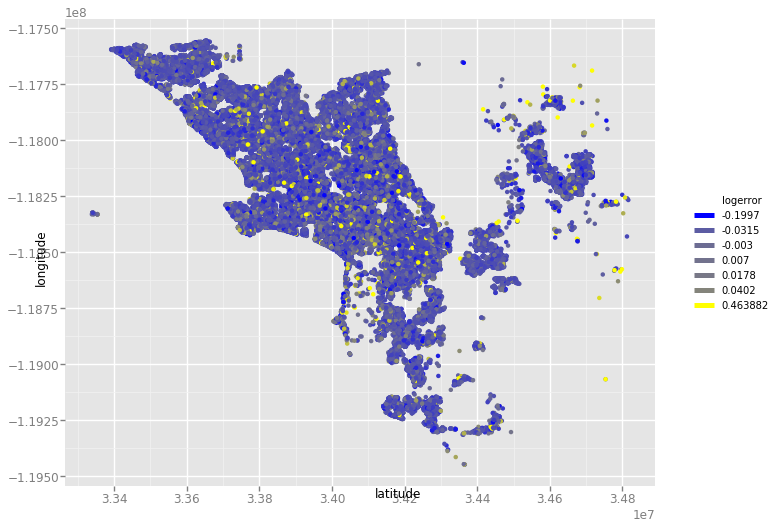

<ggplot: (280429105)>

In [14]:
# geographical logerror distribution
from ggplot import *
ggplot(
       aes(x='latitude', 
           y='longitude', 
           color='logerror'),
        data = df_train[(df_train.logerror < 0.5) & (df_train.logerror > -0.2)],
       ) + \
    geom_point() + \
    scale_color_gradient(low = 'blue', high = 'yellow')

<div class="alert alert-block alert-info">
seems pretty random. 
no obvious bias in Zillow's Zestimate prediction

### check time distribution of transactions

Text(0.5,1,u'histogram of time: transaction date ')

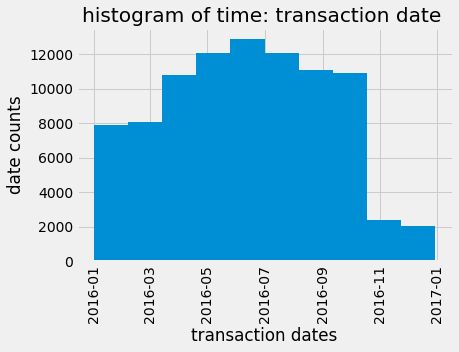

In [15]:
ax = df_transactions.transactiondate.hist(xrot=90)
ax.set_xlabel("transaction dates")
ax.set_ylabel("date counts")
ax.set_title("histogram of time: transaction date ")

<div class="alert alert-block alert-info">
there is a dip in between 2016-10-01 and 2017-01-01

this is exepected: competition setup
some of the data is hiden to score public leaderboard

### check the missing values situation of training set

In [16]:
# check missing values
df_nan = df_properties.isnull().sum(axis=0).reset_index()
df_nan.head()
df_nan.columns = ['column_name', 'nan_count']
df_nan = df_nan.ix[df_nan['nan_count']>0]
df_nan['nan_rate'] = df_nan['nan_count']*100.0/ df_properties.shape[0]
df_nan = df_nan.sort_values(by='nan_rate', ascending=False)
df_nan.head(10)

,column_name,nan_count,nan_rate
41,storytypeid,2983593,99.945599
3,basementsqft,2983589,99.945465
46,yardbuildingsqft26,2982570,99.911330
49,fireplaceflag,2980054,99.827048
2,architecturalstyletypeid,2979156,99.796966
43,typeconstructiontypeid,2978470,99.773986
13,finishedsquarefeet13,2977545,99.743000
6,buildingclasstypeid,2972588,99.576949
9,decktypeid,2968121,99.427311
16,finishedsquarefeet6,2963216,99.263002


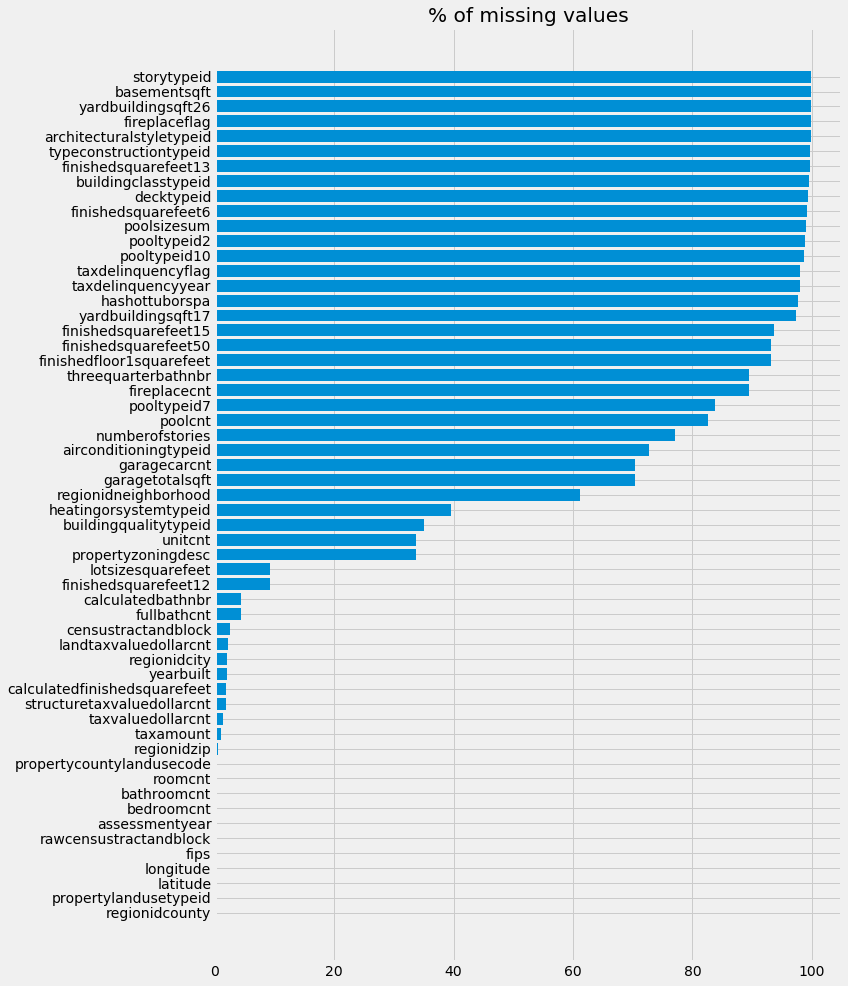

In [17]:
# let's visualize them out for more intuitive view:
df_nan = df_nan.sort_values(by='nan_rate', ascending=True)
ind = np.arange(df_nan.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,16))
rects = ax.barh(ind, 1.0*df_nan.nan_rate)
ax.set_yticks(ind)
ax.set_yticklabels(df_nan.column_name.values, rotation='horizontal')
ax.set_title('% of missing values')
plt.show()

<div class="alert alert-block alert-info">

- Some features storytypeid has many missing values!

- need to remove some if it gets too extreme (cause overfitting)
- can do a cross check if these appreas to have high importance in models

### some further checks on important features 
<div class="alert alert-block alert-info">
tax has high prediction power, let's check

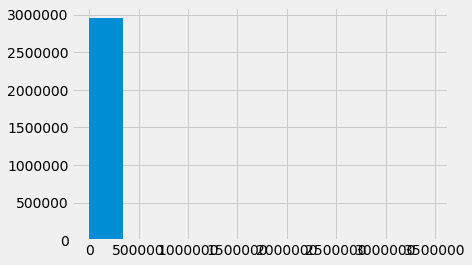

In [18]:
df_properties.taxamount.hist()
# it seems to be hugely skewed on the long tail end
# let me apply a log and look at it again

Text(0.5,1,u'histogram of taxamount ')

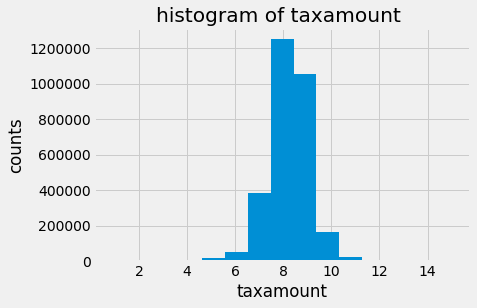

In [19]:
ax = np.log(df_properties.taxamount+1).hist(bins=15)
ax.set_xlabel("taxamount")
ax.set_ylabel("counts")
ax.set_title("histogram of taxamount ")
# this looks much more reasonable

<a id="section_3"></a>
# 3. Merge data 

In [20]:
# df = pd.merge(left=df_properties, right=df_transactions, on='parcelid')
# merge the two set 
df_train = pd.concat([df_train_2016, df_train_2017], axis = 0)

In [21]:
# df_pred = pd.merge(left=df_properties, right=df_transactions.drop_duplicates(subset='parcelid',keep='first'), on='parcelid', how='left')
df_pred_2016 = pd.merge(sample_submission[['ParcelId']], df_properties_2016.rename(columns = {'parcelid': 'ParcelId'}), 
                how = 'left', on = 'ParcelId')
df_pred_2017 = pd.merge(sample_submission[['ParcelId']], df_properties_2017.rename(columns = {'parcelid': 'ParcelId'}), 
                how = 'left', on = 'ParcelId')
df_pred = df_pred_2017

In [22]:
# check uniqueness of parcel_id in df_train
(df_train['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    162541
2      2660
3         9
Name: parcelid, dtype: int64

<div class="alert alert-block alert-info">
in reality, a house can be sold multiple times in the training set

this rate of appearances seems fine

for simplicity consideration, I will just leave it as is

In [23]:
df_pred_2016.shape

(2985217, 58)

In [24]:
sample_submission.shape

(2985217, 7)

In [25]:
sample_submission.head()
# this is the format of the submission file - 
# it requires us to make a monthly prediction for every parcel in an area
# this is because zillow has no idea which parcel will get sold or not ahead of time

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


<a id="section_4"></a>
# 4. Prepare data for training

<a id="section_4_a"></a>
## 4a. feature engineering

<div class="alert alert-block alert-info">
here I am generating some very simple features - 
mostly are interaction features accoridng to some first intuitions

In [26]:
def add_time_and_interaction_features(df):
    # month and quarter of transaction (need to be careful with this one)
    df["f_num_month"] = df["transactiondate"].dt.month
    df["f_num_quarter"] = df["transactiondate"].dt.quarter
    
    ###  some interaction features, in case I will use a linear model ## 
    # proportion of living area 
    df['f_num_LivingAreaProp'] = df['calculatedfinishedsquarefeet']/df['lotsizesquarefeet']
    df['f_num_LivingAreaProp2'] = df['finishedsquarefeet12']/df['finishedsquarefeet15']

    # amout of extra space
    df['f_num_ExtraSpace'] = df['lotsizesquarefeet'] - df['calculatedfinishedsquarefeet'] 
    df['f_num_ExtraSpace-2'] = df['finishedsquarefeet15'] - df['finishedsquarefeet12'] 

    # total number of rooms
    df['f_num_TotalRooms'] = df['bathroomcnt'] + df['bedroomcnt']

    # Average room size
    # df['f_num_AvRoomSize'] = df['calculatedfinishedsquarefeet']/df['roomcnt'] 

    # Number of Extra rooms
    df['f_num_ExtraRooms'] = df['roomcnt'] - df['f_num_TotalRooms'] 

    # Ratio of the built structure value to land area
    # df['f_num_ValueProp'] = df['structuretaxvaluedollarcnt']/df['landtaxvaluedollarcnt']

    # Does property have a garage, pool or hot tub and AC?
    df['f_num_GarPoolAC'] = ((df['garagecarcnt']>0) & (df['pooltypeid10']>0) & (df['airconditioningtypeid']!=5))*1 

    # polnomials of the variable - important features, 
    df["f_num_structuretaxvaluedollarcnt-2"] = df["structuretaxvaluedollarcnt"] ** 2
    df["f_num_structuretaxvaluedollarcnt-3"] = df["structuretaxvaluedollarcnt"] ** 3

    # Ratio of tax of property over parcel
    # df['f_num_ValueRatio'] = df['taxvaluedollarcnt']/df['taxamount']

    #TotalTaxScore
    df['f_num_TaxScore'] = df['taxvaluedollarcnt']*df['taxamount']

    return df

In [27]:
df_train = add_time_and_interaction_features(df_train)

<div class="alert alert-block alert-info">
additional features built based on aggregations on regions

In [28]:
def add_location_aggregated_features(df_train, df_pred):
    # different regions I want to aggregate by
    parcel_location_variables = ['regionidneighborhood',
                                     'regionidzip', 
                                     'regionidcity', 
                                     #'censustrack',
                                     'rawcensustractandblock']

    for region in parcel_location_variables:
        #### COUNT OF PROPERTIES ####
        # number of properties in the zipcode
        group = df_pred[region].value_counts().to_dict()
        df_pred['f_num_n_prop_in_'+region] = df_pred[region].map(group)
        df_train['f_num_n_prop_in_'+region] = df_train[region].map(group)

        ##### HOW NEW IS THIS BUILDING COMPARING TO OTHER BUILDINGS #####
        group = df_pred.groupby(region)['yearbuilt'].aggregate('median').to_dict()
        df_pred['f_num_median_year_in_'+region] = df_pred[region].map(group)
        df_train['f_num_median_year_in_'+region] = df_train[region].map(group)

        df_pred['f_num_how_new_in_'+region] = df_pred['yearbuilt'] - df_pred['f_num_median_year_in_'+region]
        df_train['f_num_how_new_in_'+region] = df_train['yearbuilt'] - df_train['f_num_median_year_in_'+region]

        # Neighborhood latitude and longitude
        group = df_pred.groupby(region)['latitude'].aggregate('median').to_dict()
        df_pred['f_num_median_lat_in_'+region] = df_pred[region].map(group)
        df_train['f_num_median_lat_in_'+region] = df_train[region].map(group)


        group = df_pred.groupby(region)['longitude'].aggregate('median').to_dict()
        df_pred['f_num_median_lon_in_'+region] = df_pred[region].map(group)
        df_train['f_num_median_lon_in_'+region] = df_train[region].map(group)

        #Average structuretaxvaluedollarcnt by city
        group = df_pred.groupby(region)['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
        df_pred['f_num_Avg-structuretaxvaluedollarcnt'] = df_pred['regionidcity'].map(group)
        df_train['f_num_Avg-structuretaxvaluedollarcnt'] = df_train['regionidcity'].map(group)

        #Deviation away from average
        df_pred['f_num_Dev-structuretaxvaluedollarcnt'] = abs((df_pred['structuretaxvaluedollarcnt'] - df_pred['f_num_Avg-structuretaxvaluedollarcnt']))/df_pred['f_num_Avg-structuretaxvaluedollarcnt']
        df_train['f_num_Dev-structuretaxvaluedollarcnt'] = abs((df_train['structuretaxvaluedollarcnt'] - df_train['f_num_Avg-structuretaxvaluedollarcnt']))/df_train['f_num_Avg-structuretaxvaluedollarcnt']
    
    return df_train, df_pred

In [29]:
df_train, df_pred = add_location_aggregated_features(df_train, df_pred)

<a id="section_4_b"></a>
## 4b. add additional features via SQL

<div class="alert alert-block alert-info">
 here I wrote some additional features in SQL
 
 more efficient feature engineering when you want to scale up
 here, I only kept some of them

In [30]:
# here I am calling the SQL computation from jupyter notebook for easier reference
!psql -d zillow -a -f /Users/fangjie/Workspace/data-science/competitions/zillow/sql_scripts/feature_engineering_time.sql

DROP TABLE IF EXISTS transactions_2016;
DROP TABLE
CREATE TABLE transactions_2016 (
	parcelid bigint, 
	logerror double precision,
	transactiondate varchar
);
CREATE TABLE
DROP TABLE IF EXISTS transactions_2017;
DROP TABLE
COPY transactions_2016
FROM '/Users/fangjie/Workspace/data-science/competitions/zillow/train_2016_v2.csv' DELIMITER ',' CSV HEADER;
COPY 90275
CREATE TABLE transactions_2017 (
	parcelid bigint, 
	logerror double precision,
	transactiondate varchar
);
CREATE TABLE
COPY transactions_2017
FROM '/Users/fangjie/Workspace/data-science/competitions/zillow/train_2017.csv' DELIMITER ',' CSV HEADER;
COPY 77613
DROP TABLE IF EXISTS transactions;
DROP TABLE
CREATE TABLE transactions AS
SELECT * FROM transactions_2016
UNION ALL
SELECT * FROM transactions_2017;
SELECT 167888
DROP TABLE IF EXISTS tmp_additional_temporal_information;
DROP TABLE
CREATE TABLE tmp_additional_temporal_information AS
SELECT 
    t.parcelid
    , t.logerror
    , t.transactiondate
    , substring(transact

In [31]:
# load the above computed features
# as you can tell, here I am actually load the log error for each month
# the foundamental assumption here is that there is some system trend with Zestimate's logerror over time
d_features = pd.read_csv(data_path+'2nd_monthly_transactions_features.csv')

<a id="section_4_b"></a>
## 4c. Temporal behavior of data
### a more proper way of using temporal information - through time series modeling

<div class="alert alert-block alert-info">
we need to predict into future monthly logerror 11/17-01/18,
need to build a forecasting model

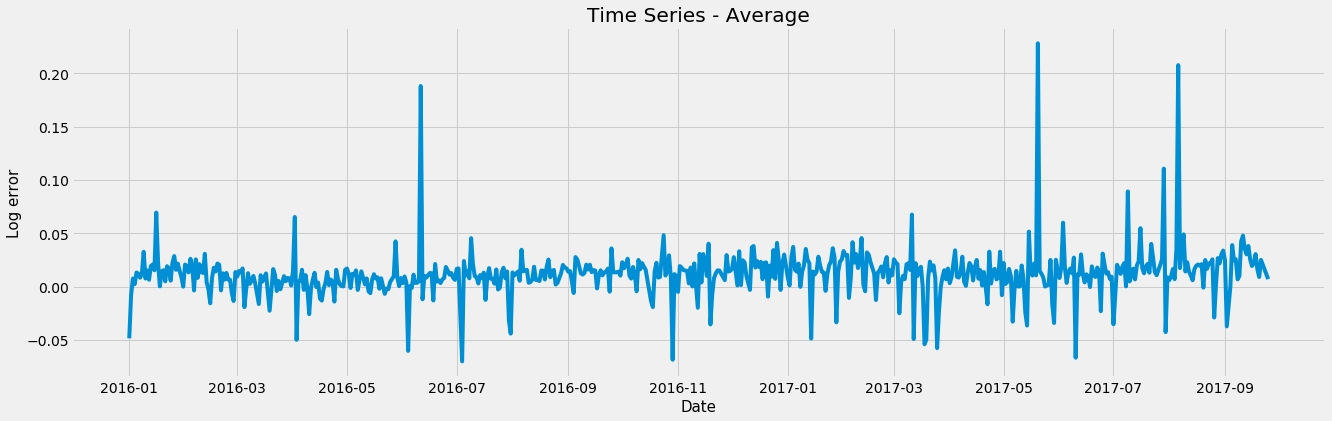

In [32]:
df = df_train
df['transaction_month'] = df['transactiondate'].dt.month
df['transaction_year'] = df['transactiondate'].dt.year
df['transaction_year_and_month'] = df['transactiondate'].astype('str').str[:7]

# train.set_index(pd.to_datetime(train.transactiondate), inplace = True)
df['transactiondate'] = pd.to_datetime(df.transactiondate)

mask = (df['transactiondate'] < '2017-10-01')
df1=df.loc[mask]

# first visualize the data
plt.figure(figsize=(20, 6))
mean_group = df1[['transactiondate','logerror']].groupby(['transactiondate'])['logerror'].mean()
plt.plot(mean_group)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Log error', fontsize=15)
plt.title('Time Series - Average')
plt.show() 

<div class="alert alert-block alert-info">
Some seasonality in this log error plot

So, time to do time series modeling

##### ARIMA Model
autoregressive integrated moving average

In [33]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]
# 12 months, 3, quarter
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 3)
SARIMAX: (0, 0, 1) x (0, 1, 0, 3)
SARIMAX: (0, 1, 0) x (0, 1, 1, 3)
SARIMAX: (0, 1, 0) x (1, 0, 0, 3)


In [34]:
# Akaike Information Criter AIC test
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(mean_group,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 3)12 - AIC:-2784.70367771
ARIMA(0, 0, 0)x(0, 1, 1, 3)12 - AIC:-2896.66479272
ARIMA(0, 0, 0)x(1, 0, 0, 3)12 - AIC:-2803.70293276
ARIMA(0, 0, 0)x(1, 0, 1, 3)12 - AIC:-2913.04621333
ARIMA(0, 0, 0)x(1, 1, 0, 3)12 - AIC:-2683.03406426
ARIMA(0, 0, 0)x(1, 1, 1, 3)12 - AIC:-2893.5751129
ARIMA(0, 0, 1)x(0, 0, 0, 3)12 - AIC:-2798.89703414
ARIMA(0, 0, 1)x(0, 0, 1, 3)12 - AIC:-2799.75846976
ARIMA(0, 0, 1)x(0, 1, 0, 3)12 - AIC:-2517.15946009
ARIMA(0, 0, 1)x(0, 1, 1, 3)12 - AIC:-2889.76113467
ARIMA(0, 0, 1)x(1, 0, 0, 3)12 - AIC:-2818.33352564
ARIMA(0, 0, 1)x(1, 0, 1, 3)12 - AIC:-2906.27784928
ARIMA(0, 0, 1)x(1, 1, 0, 3)12 - AIC:-2682.05205411
ARIMA(0, 0, 1)x(1, 1, 1, 3)12 - AIC:-2887.22131918
ARIMA(0, 1, 0)x(0, 0, 1, 3)12 - AIC:-2521.97894632
ARIMA(0, 1, 0)x(0, 1, 1, 3)12 - AIC:-2493.75156679
ARIMA(0, 1, 0)x(1, 0, 0, 3)12 - AIC:-2527.05403626
ARIMA(0, 1, 0)x(1, 0, 1, 3)12 - AIC:-2520.03081029
ARIMA(0, 1, 0)x(1, 1, 0, 3)12 - AIC:-2281.35941722
ARIMA(0, 1, 0)x(1, 1, 1, 3)12 - 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2764      0.043     -6.460      0.000      -0.360      -0.193
ar.L2         -0.0576      0.059     -0.969      0.333      -0.174       0.059
ma.L1         -2.0887      0.029    -71.436      0.000      -2.146      -2.031
ma.L2          1.0892      0.031     35.328      0.000       1.029       1.150
ar.S.L12      -0.2530      0.191     -1.324      0.186      -0.628       0.122
ar.S.L24      -0.1445      0.074     -1.965      0.049      -0.289      -0.000
ma.S.L12      -1.2221      0.234     -5.225      0.000      -1.681      -0.764
ma.S.L24       0.2289      0.187      1.227      0.220      -0.137       0.595
sigma2         0.0006      0.000      4.235      0.000       0.000       0.001


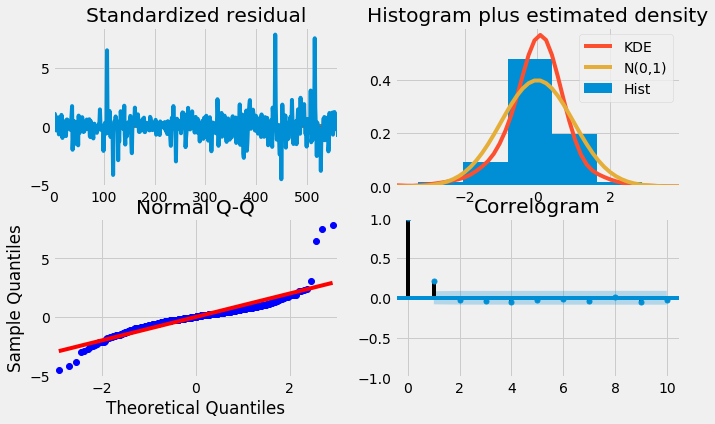

In [35]:
mod = sm.tsa.statespace.SARIMAX(mean_group.values,
                                order=(2, 2, 2),
                                seasonal_order=(2, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])
results.plot_diagnostics(figsize=(10, 6))
plt.show()

##### ARIMA Prediction

In [36]:
pred = results.get_prediction(start=0,dynamic=False)
y_forecasted = pred.predicted_mean
y_truth = mean_group[0:]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 5)))

The Mean Squared Error of our forecasts is 0.00107


In [37]:
pred_uc=results.get_forecast(steps=97)
forcast = pd.DataFrame( pred_uc.predicted_mean ) 
new_transactiondate = pd.date_range('2017-09-26', periods=97, freq='1D')
columns=[['transactiondate','logerror']]
forcast_from_oct17=pd.DataFrame(columns=columns)

forcast_from_oct17['transactiondate']=new_transactiondate
forcast_from_oct17['logerror']=forcast
forcast_from_oct17.dropna()
forcast_from_oct17.tail()

logerrors=pd.DataFrame( pred.predicted_mean ) 

prediction=pd.DataFrame(columns=columns)

prediction['transactiondate']=pd.to_datetime(mean_group.index)

prediction['logerror'] = logerrors

prediction.head()

data=pd.concat([prediction, forcast_from_oct17])
data.head()

,transactiondate,logerror
0,2016-01-01,0.000000
1,2016-01-02,-0.084212
2,2016-01-03,0.026171
3,2016-01-04,0.025586
4,2016-01-05,-0.000584


##### ARIMA Forcasting

Text(0,0.5,u'logerror')

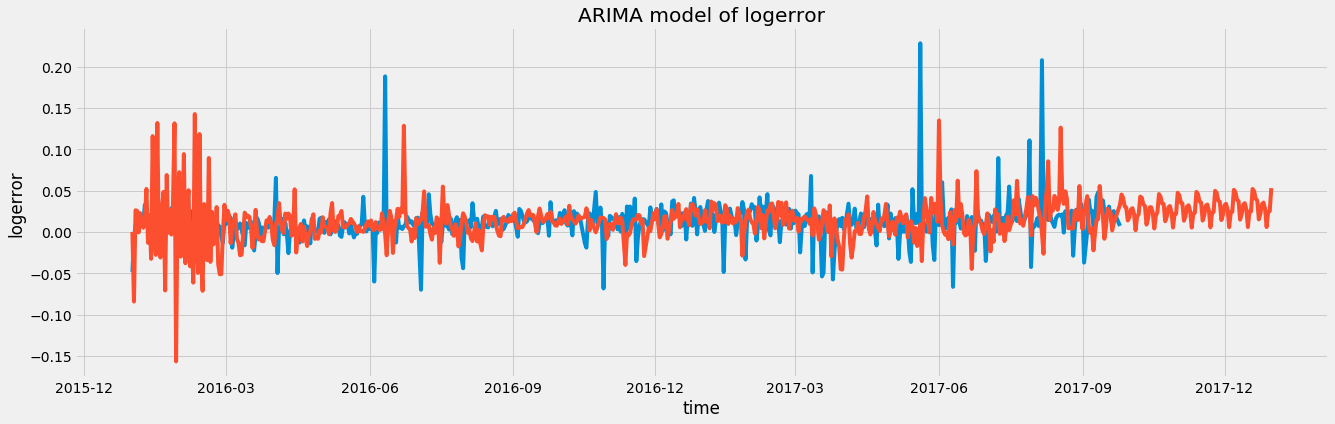

In [38]:
plt.figure(figsize=(20, 6))
xx=data.transactiondate
yy=data.logerror
plt.plot(mean_group,label='Zestimate logerror')
plt.plot(xx, yy,label='ARIMA prediction')
plt.xlabel('time')
plt.title('ARIMA model of logerror')
plt.ylabel('logerror')

<div class="alert alert-block alert-info">

let's aggregate them and use these time series forcasting data into training!

In [39]:
data.to_csv(data_path+'arima_model_month.csv', index=False, float_format='%.6f') 

In [40]:
data.head()

,transactiondate,logerror
0,2016-01-01,0.000000
1,2016-01-02,-0.084212
2,2016-01-03,0.026171
3,2016-01-04,0.025586
4,2016-01-05,-0.000584


In [41]:
data['transaction_year_and_month'] = data['transactiondate'].astype('str').str[:7]

In [42]:
df_feats_temporal = data.groupby('transaction_year_and_month').aggregate(['mean', 'std'])
df_feats_temporal

logerror          
                                mean       std
transaction_year_and_month                    
2016-01                     0.014079  0.059062
2016-02                     0.003275  0.054715
2016-03                     0.003701  0.016383
2016-04                     0.004996  0.016149
2016-05                     0.008803  0.008865
2016-06                     0.011694  0.026020
2016-07                     0.009733  0.017703
2016-08                     0.006609  0.011676
2016-09                     0.014969  0.007280
2016-10                     0.013844  0.008050
2016-11                     0.006940  0.014360
2016-12                     0.017084  0.011249
2017-01                     0.016893  0.012607
2017-02                     0.018148  0.011807
2017-03                     0.005613  0.019163
2017-04                     0.007449  0.015216
2017-05                     0.010820  0.016386
2017-06                     0.015029  0.031694
2017-07                     0.014601  0.017685
2017-08                     0.030596  0.027287
2017-09                     0.018283  0.018231
2017-10                     0.024657  0.011208
2017-11                     0.029412  0.012518
2017-12                     0.030016  0.013040

In [43]:
# merge with training set
group = df_feats_temporal['logerror']['mean'].to_dict()
df_train['f_num_monthly_avg_logerror'] = df_train['transaction_year_and_month'].map(group)

group = df_feats_temporal['logerror']['std'].to_dict()
df_train['f_num_monthly_std_logerror'] = df_train['transaction_year_and_month'].map(group)

<a id="section_4_d"></a>
## 4d. impute missing data 

<div class="alert alert-block alert-info">
- I need to first clearly define what are the **correct types** of data I have. 
doing this through set operations.

non-linear models
- I will imputing -1 for numeric values, and then use label encoder to encode all categorical variables

In [44]:
df = df_train

all_fields = set(df.columns)

# these are fields that are used to identify fields
identifiers = set(['transactiondate', 'parcelid'])

# log error that we want to model
label = set(['logerror'])

# the following are categorical features
feats_objects = set(
 ['taxdelinquencyflag',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'fireplaceflag',
 'hashottuborspa']
)

# the following are numerical features that should be treated as categorical features
feats_categorical_as_numeric = set([
    'airconditioningtypeid',
    'architecturalstyletypeid',
    'buildingqualitytypeid',
    'buildingclasstypeid',
    'decktypeid',
    'fips',
    'heatingorsystemtypeid',
    'propertylandusetypeid',
    'regionidcounty',
    'regionidcity',
    'regionidzip',
    'regionidneighborhood',
    'storytypeid',
    'typeconstructiontypeid',
])


# the rest are numeric features
feats_numeric = set([
    'basementsqft',
    'bathroomcnt',
    'bedroomcnt',
    'calculatedbathnbr',
    'threequarterbathnbr',
    'finishedfloor1squarefeet',
    'calculatedfinishedsquarefeet',
    'finishedsquarefeet6',
    'finishedsquarefeet12',
    'finishedsquarefeet13',
    'finishedsquarefeet15',
    'finishedsquarefeet50',
    'fireplacecnt',
    'fullbathcnt',
    'garagecarcnt',
    'garagetotalsqft',
    'hashottuborspa',
    'lotsizesquarefeet',
    'numberofstories',
    'poolcnt',
    'poolsizesum',
    'pooltypeid10',
    'pooltypeid2',
    'pooltypeid7',
    'roomcnt',
    'unitcnt',
    'yardbuildingsqft17',
    'yardbuildingsqft26',
    'taxvaluedollarcnt',
    'structuretaxvaluedollarcnt',
    'landtaxvaluedollarcnt',
    'taxamount',
    'latitude',
    'longitude',
    'yearbuilt',
    'assessmentyear',
    'taxdelinquencyyear',
    'rawcensustractandblock',
    'censustractandblock',
])

feats_numerics_feature_engineered = set([col for col in df.columns if 'f_num' in col or '_logerror' in col])


feats_categorical_feature_engineered = set([col for col in df.columns if 'f_cat' in col])


# fields that are thrown away for now
feats_for_consideration_later = set([
])

In [45]:
feats_categorical = feats_objects | feats_categorical_feature_engineered
feats_numeric = feats_numeric | feats_numerics_feature_engineered | feats_categorical_as_numeric
feats = feats_categorical | feats_numeric 

feats_categorical_as_numeric = list(feats_categorical_as_numeric)
feats_categorical = list(feats_categorical)
feats_numeric = list(feats_numeric)
feats = list(feats)

In [46]:
feats_numeric

['finishedfloor1squarefeet',
 'numberofstories',
 'regionidcity',
 'regionidzip',
 'landtaxvaluedollarcnt',
 'regionidcounty',
 'f_num_median_lat_in_regionidneighborhood',
 'pooltypeid10',
 'f_num_LivingAreaProp2',
 'f_num_how_new_in_regionidcity',
 'f_num_n_prop_in_regionidcity',
 'structuretaxvaluedollarcnt',
 'poolsizesum',
 'f_num_n_prop_in_rawcensustractandblock',
 'f_num_median_lon_in_regionidneighborhood',
 'poolcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'bedroomcnt',
 'basementsqft',
 'hashottuborspa',
 'f_num_ExtraSpace-2',
 'buildingqualitytypeid',
 'f_num_GarPoolAC',
 'propertylandusetypeid',
 'regionidneighborhood',
 'decktypeid',
 'heatingorsystemtypeid',
 'architecturalstyletypeid',
 'rawcensustractandblock',
 'f_num_quarter',
 'f_num_median_lon_in_regionidzip',
 'f_num_structuretaxvaluedollarcnt-3',
 'f_num_structuretaxvaluedollarcnt-2',
 'longitude',
 'f_num_TaxScore',
 'taxvaluedollarcnt',
 'f_num_median_year_in_regionidzip',
 'f_num_n_prop_in_regionidzip',
 

In [47]:
feats_categorical

['taxdelinquencyflag',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'fireplaceflag',
 'hashottuborspa']

### under a non-linear model set-up: 
I will imputing -1 for numeric values, and then use label encoder to encode all categorical variables

In [48]:
# for numeric variables, fill with a big negative number
df[feats_numeric] = df[feats_numeric].fillna(-999)
# df_pred[feats_numeric] = df_pred[feats_numeric].fillna(-999)

In [49]:
# use label encoder to encode all categorical variables
for column in feats_categorical:
    tmp = pd.concat([df[column], df_pred_2016[column], df_pred_2017[column]], axis = 0)
    encoder = LabelEncoder().fit(tmp.astype(str))
    df[column] = encoder.transform(df[column].astype(str)).astype(np.int32)
    df_pred[column] = encoder.transform(df_pred[column].astype(str)).astype(np.int32)

In [50]:
# the following strategy is for using a linear model

# imp =  Imputer(missing_values=np.nan, strategy="median", axis=0)
# # df[feats_numeric] = imp.fit_transform(df[feats_numeric])
# for feat in feats_numeric:
#     if df[feat].isnull().sum() < df.shape[0]:
#         df[[feat]] = imp.fit_transform(df[[feat]])
#     else:
#         df[feat] = 0

<a id="section_4_e"></a>
## 4e. let's do some final checks on the data to be used for training


<a id="section_4_e_1"></a>
### look at importances of features through a quick tree model

In [51]:
df_tmp = df_train
train_y = df_tmp['logerror'].values
df_tmp = df_train.drop(['parcelid',
                        'logerror',
                        'transactiondate',
                        'hashottuborspa',
                        'propertycountylandusecode',
                        'propertyzoningdesc',
                        'fireplaceflag',
                        'taxdelinquencyflag',
                        'transaction_year_and_month',
                        'transaction_year',
                        'transaction_month',
                       ], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}


dtrain = xgb.DMatrix(df_tmp, train_y, feature_names=df_tmp.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

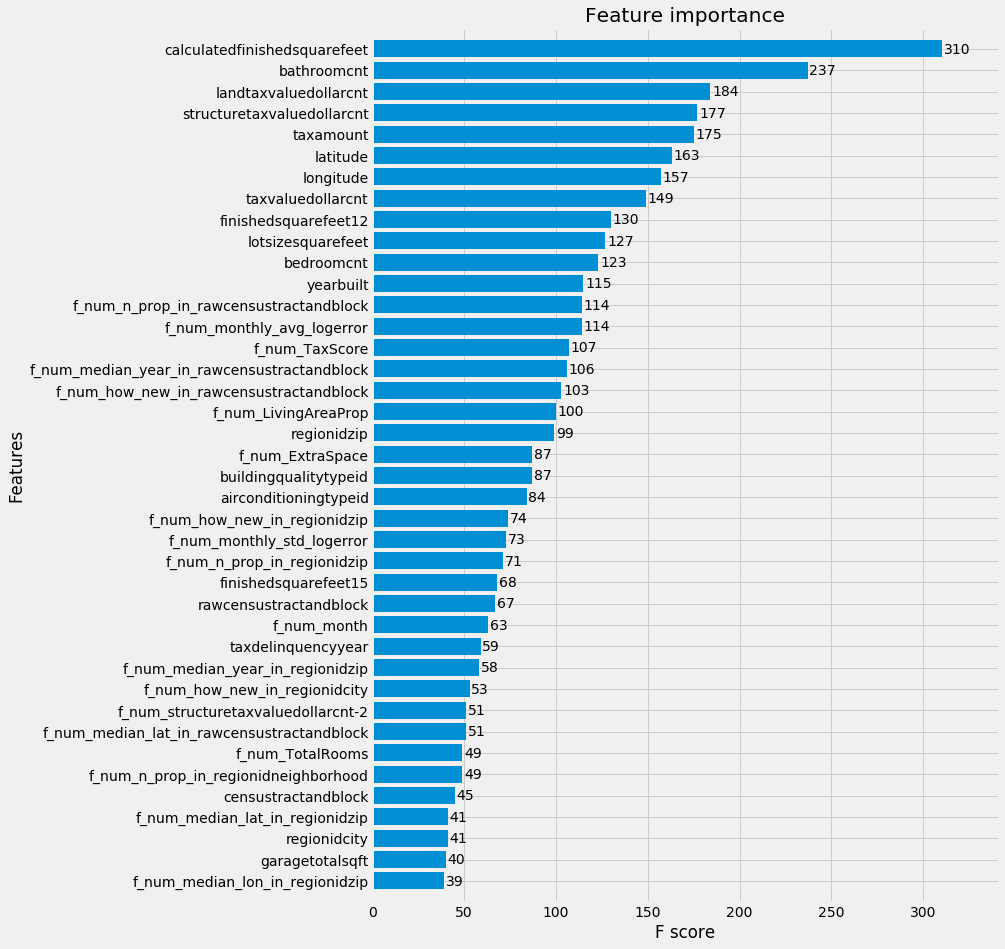

In [52]:
# plot the important features
fig, ax = plt.subplots(figsize=(10,15))
xgb.plot_importance(model, importance_type = 'weight', max_num_features=40, height=0.8, ax=ax)
plt.show()

# ‘weight’ - the number of times a feature is used to split the data across all trees. 
# ‘gain’ - the average gain of the feature when it is used in trees 
# ‘cover’ - the average coverage of the feature when it is used in trees

<div class="alert alert-block alert-info">
This makes sense.

If I'm gonna buy a house, I would consider those top features, like, square feet, # bathrooms, tax amount, location etc

<a id="section_4_f"></a>
## 4f.  finalize training and testing sets

In [53]:
# reset indexies
df.reset_index(drop=True, inplace = True)
df.reset_index(drop=True, inplace = True)

# define training and testing masks
mask_train = (df.transactiondate <= '2017-06-01')
mask_test = (df.transactiondate > '2017-06-01')

In [54]:
# finally let's remove some outliers from training
# some extra filtering to remove outliers
mask_outlier = (df.logerror > 0.4) | (df.logerror < -0.4)

# also remove features that leaks future information
try:
    feats.remove('f_num_stddev_logerror')
    feats.remove('f_num_avg_logerror')
except:
    True

In [55]:
# generate the training data sets
X_train = df.loc[(mask_train & ~mask_outlier), feats].astype(np.float32).values
X_test = df.loc[mask_test, feats].astype(np.float32).values

y_train = np.array(df.loc[(mask_train & ~mask_outlier), 'logerror'].astype(np.float32).tolist())
y_test = np.array(df.loc[mask_test, 'logerror'].astype(np.float32).tolist())

data = (X_train, X_test, y_train, y_test)

In [56]:
# serialize data for quicker future reuse
pickle.dump(data, open('/Users/fangjie/Workspace/data-science/competitions/zillow/training_and_testing_data.pkl', 'w'))
pickle.dump(data, open('/Users/fangjie/Workspace/data-science/competitions/zillow/df_train.pkl', 'w'))

<a id="section_5"></a>
# 5. Train models

In [57]:
X_train, X_test, y_train, y_test = pickle.load(open('/Users/fangjie/Workspace/data-science/competitions/zillow/training_and_testing_data.pkl', 'r'))

<div class="alert alert-block alert-info">
regression problem : to predict logerror from feature set

- LightGBM
- Xgboost
- Random Forest
- CatBoost


<a id="section_5_a"></a>
## 5a. LightGBM
lightgbm trains fast and has really good performances. 
but requires quite some parameter tuning..

In [58]:
# define paramters to grid search through..
params = {
    # 'max_bin': [10],
    'max_depth': [20, 40],
    'num_leaves': [20, 40],
    #'feature_fraction': [0.85],
    #'bagging_fraction': [0.95],
    #'bagging_freq': [8],
    'learning_rate': [0.01],
}

In [59]:
start = time.time()
scorer = make_scorer(mean_absolute_error)
model = lgb.LGBMRegressor(boosting_type = 'gbdt', 
                          metric='mae', 
                          verbosity=0, 
                          #verbose_eval=200, 
                          num_boost_round=10,
                          bagging_seed=42, 
                          feature_fraction_seed=42,
                          n_jobs = 1
                          )

# doing grid search from the parameters defined above
grid = GridSearchCV(model, params, scoring=scorer,
                          cv=3, verbose=2, n_jobs=1)
grid.fit(X_train, y_train)
print("[INFO] randomized search took {:.2f} seconds".format(
    time.time() - start))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] num_leaves=20, learning_rate=0.01, max_depth=20 .................
[CV] .. num_leaves=20, learning_rate=0.01, max_depth=20, total=   1.9s
[CV] num_leaves=20, learning_rate=0.01, max_depth=20 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] .. num_leaves=20, learning_rate=0.01, max_depth=20, total=   1.7s
[CV] num_leaves=20, learning_rate=0.01, max_depth=20 .................
[CV] .. num_leaves=20, learning_rate=0.01, max_depth=20, total=   1.8s
[CV] num_leaves=40, learning_rate=0.01, max_depth=20 .................
[CV] .. num_leaves=40, learning_rate=0.01, max_depth=20, total=   1.9s
[CV] num_leaves=40, learning_rate=0.01, max_depth=20 .................
[CV] .. num_leaves=40, learning_rate=0.01, max_depth=20, total=   1.9s
[CV] num_leaves=40, learning_rate=0.01, max_depth=20 .................
[CV] .. num_leaves=40, learning_rate=0.01, max_depth=20, total=   1.9s
[CV] num_leaves=20, learning_rate=0.01, max_depth=40 .................
[CV] .. num_leaves=20, learning_rate=0.01, max_depth=40, total=   1.8s
[CV] num_leaves=20, learning_rate=0.01, max_depth=40 .................
[CV] .. num_leaves=20, learning_rate=0.01, max_depth=40, total=   1.8s
[CV] num_leaves=20, learning_rate=0.01, max_depth=40 .................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   24.2s finished


[INFO] randomized search took 26.51 seconds


In [60]:
# prediction for test set and prediction set
y_pred = grid.predict(X_test)

In [61]:
mae = grid.score(X_test, y_test)
print("[INFO] grid search MAE: {:.6f}".format(mae))
print("[INFO] randomized search best parameters: {}".format(
    grid.best_params_))

[INFO] grid search MAE: 0.069445
[INFO] randomized search best parameters: {'num_leaves': 20, 'learning_rate': 0.01, 'max_depth': 20}


In [62]:
print 'MAE:{}'.format(round(mean_absolute_error(y_pred=y_pred, y_true=y_test),6))

MAE:0.069445


In [63]:
y_pred_lgb = y_pred
x_ensemble_lgb = grid.predict(X_train)

<a id="section_5_b"></a>
## 5b. XgBoost
another gradient boosting with fast and great performance 

In [64]:
# xgboost params
params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': np.mean(y_train),
    'silent': 1
}

In [65]:
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test)

In [66]:
num_boost_rounds = 100
fit = xgb.train(dict(params, silent=1), d_train, num_boost_round=num_boost_rounds)

In [67]:
# prediction for test set and prediction set
y_pred = fit.predict(d_test)

In [68]:
print 'MAE:{}'.format(round(mean_absolute_error(y_pred=y_pred, y_true=y_test),6))

MAE:0.069014


In [69]:
y_pred_xgb = y_pred
x_ensemble_xgb = fit.predict(xgb.DMatrix(X_train))

<a id="section_5_c"></a>
## 5c. Random Forest
easy to use, popular one

In [70]:
params = {
    "max_depth": 10,
    "min_samples_split": 50,
    "n_estimators": 50
}

In [71]:
fit = RandomForestRegressor(random_state=42, n_jobs=2, verbose=1, **params)
fit.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  1.2min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=50,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=2,
           oob_score=False, random_state=42, verbose=1, warm_start=False)

In [72]:
# prediction for test set and prediction set
y_pred = fit.predict(X_test)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.1s finished


In [73]:
print 'MAE:{}'.format(round(mean_absolute_error(y_pred=y_pred, y_true=y_test),6))

MAE:0.069199


In [74]:
y_pred_rf = y_pred
x_ensemble_rf = fit.predict(X_train)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.3s finished


<a id="section_5_d"></a>
## 5e. <font color=green>**CatBoost**: </font>
need less parameter tuning, robust, optimization on categorical features

In [75]:
num_ensembles = 5
y_pred = 0.0
x_ensemble_cbt = 0.0
# below i am using avg of a few catboost models..
# a simple stacking ensemble
for i in tqdm(range(num_ensembles)):
    model = CatBoostRegressor(
        iterations=50, 
        learning_rate=0.03,
        depth=6, 
        l2_leaf_reg=3,
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=i)
    
    model.fit(
        X_train, y_train,
        #cat_features=cat_feature_inds
    )
    y_pred += model.predict(X_test)
    x_ensemble_cbt = model.predict(X_train)
y_pred /= num_ensembles
x_ensemble_cbt /= num_ensembles

100%|██████████| 5/5 [01:27<00:00, 17.10s/it]


In [76]:
print 'MAE:{}'.format(round(mean_absolute_error(y_pred=y_pred, y_true=y_test),6))

MAE:0.068801


In [77]:
y_pred_cbt = y_pred
x_ensemble_cbt = x_ensemble_cbt

<a id="section_6"></a>
# 6. Visualizations

<div class="alert alert-block alert-info">
point wise catboost seems to be doing best

let's try to visualize the prediction results to see if they complement to each othter

Text(0.5,0.98,u'Actual value (x) vs. predicted value (y)')

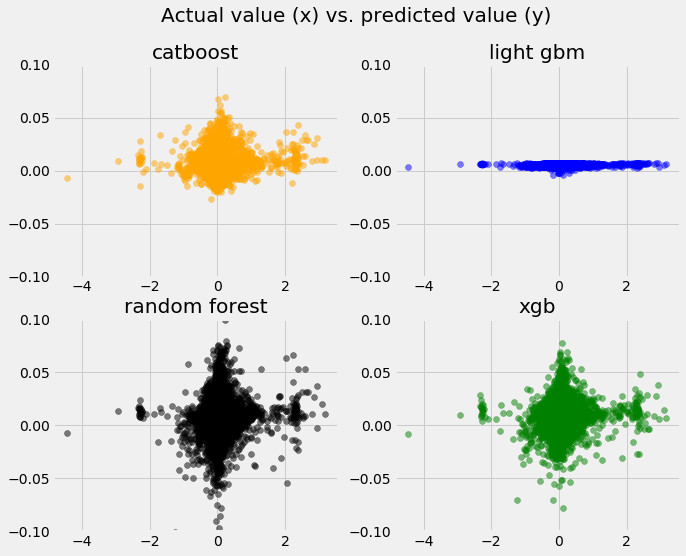

In [78]:
# lets check scatter plot..
fig, axs = plt.subplots(2,2,figsize = (10,8))
axs[0,0].scatter(x = y_test, y = y_pred_cbt, color='orange', alpha=0.5)
axs[0,1].scatter(x = y_test, y = y_pred_lgb, color='blue', alpha=0.5)
axs[1,0].scatter(x = y_test, y = y_pred_rf, color='black', alpha=0.5)
axs[1,1].scatter(x = y_test, y = y_pred_xgb, color='green', alpha=0.5)

axs[0,0].set_title('catboost')
axs[0,1].set_title('light gbm')
axs[1,0].set_title('random forest')
axs[1,1].set_title('xgb')

axs[0,0].set_ylim(-0.1, 0.1)
axs[0,1].set_ylim(-0.1, 0.1)
axs[1,0].set_ylim(-0.1, 0.1)
axs[1,1].set_ylim(-0.1, 0.1)

fig.suptitle("Actual value (x) vs. predicted value (y)", fontsize=20)

<div class="alert alert-block alert-info">
- four models behave differently
- ensemble model may provide a better result

<a id="section_7_a"></a>
# 7. Ensemble - a meta model approach

### 1st:  let's use an elastic net to combine them together lineraly

In [79]:
X_train_ensemble = pd.DataFrame(
    {
        'lgb':x_ensemble_lgb,
        'xgb':x_ensemble_xgb,
        'rf':x_ensemble_rf,
        'cbt':x_ensemble_cbt
    }
)

In [80]:
X_test_ensemble = pd.DataFrame(
    {
        'lgb':y_pred_lgb,
        'xgb':y_pred_xgb,
        'rf':y_pred_rf,
        'cbt':y_pred_cbt
    }
)

In [81]:
params = {
    'l1_ratio':[0.1, 0.5, 0.9]
    
}

In [82]:
fit = ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto', random_state=42,
       selection='cyclic', tol=0.0001, verbose=0, **params)
fit.fit(X_train_ensemble, y_train)


ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.9], max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto', random_state=42,
       selection='cyclic', tol=0.0001, verbose=0)

In [83]:
# prediction for test set and prediction set
y_pred = fit.predict(X_test_ensemble)

In [84]:
print 'MAE:{}'.format(round(mean_absolute_error(y_pred=y_pred, y_true=y_test),6))

MAE:0.071489


### Another option: simple weighted stacking ###

In [85]:
model_weights = {
    'lgb': 0.1,
    'xgb': 1,
    'rf': 1,
    'cbt':2,
    'baseline':0.0,
}

In [86]:
pred_all = 0
y_pred_baseline = 0
for model_name, model_weight in model_weights.iteritems():
    pred_all += eval('y_pred_'+model_name) * model_weight
pred_all = pred_all / sum(model_weights.values())

In [87]:
print 'MAE:{}'.format(round(mean_absolute_error(y_pred=pred_all, y_true=y_test),6))

MAE:0.068846


<div class="alert alert-block alert-info">
this result is better than any of the individual model's results